# Annotate localized Ovenbird songs to individuals

develop a library of individual Ovenbird songs by reviewing localized songs

- view and annotate only annotate the audio from the recorder closest to the bird location
- then apply this label to other clips that recorded the same event
- remove any events where Ovenbird song is not present

> Note: the full audio data used by this script is not provided in this repository, the script is provided for reference only


In [ ]:
# imports
from opensoundscape import Audio, Spectrogram
import IPython
import pandas as pd
from matplotlib import pyplot as plt

def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

Will annotate the selected events from the validation and test sets

In [ ]:
splits_path = "REDACTED"  # location of saved val/test set csvs, matches splits_path of 6_select_clips_to_anotate.ipynb

val_df = pd.read_csv(f"{splits_path}/test_to_annotate.csv")
val_df["aiid_label"] = None
view_seconds = 4

In [ ]:
i = 0  # can choose starting position for annotation here

We use this cell to view spectrograms and audio widgets in the notebook, but enter annotations into a separate spreadsheet.

idx: 0  event: SBT-6-76_oven_0000


/home/sml161/miniconda3/envs/opso0110/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


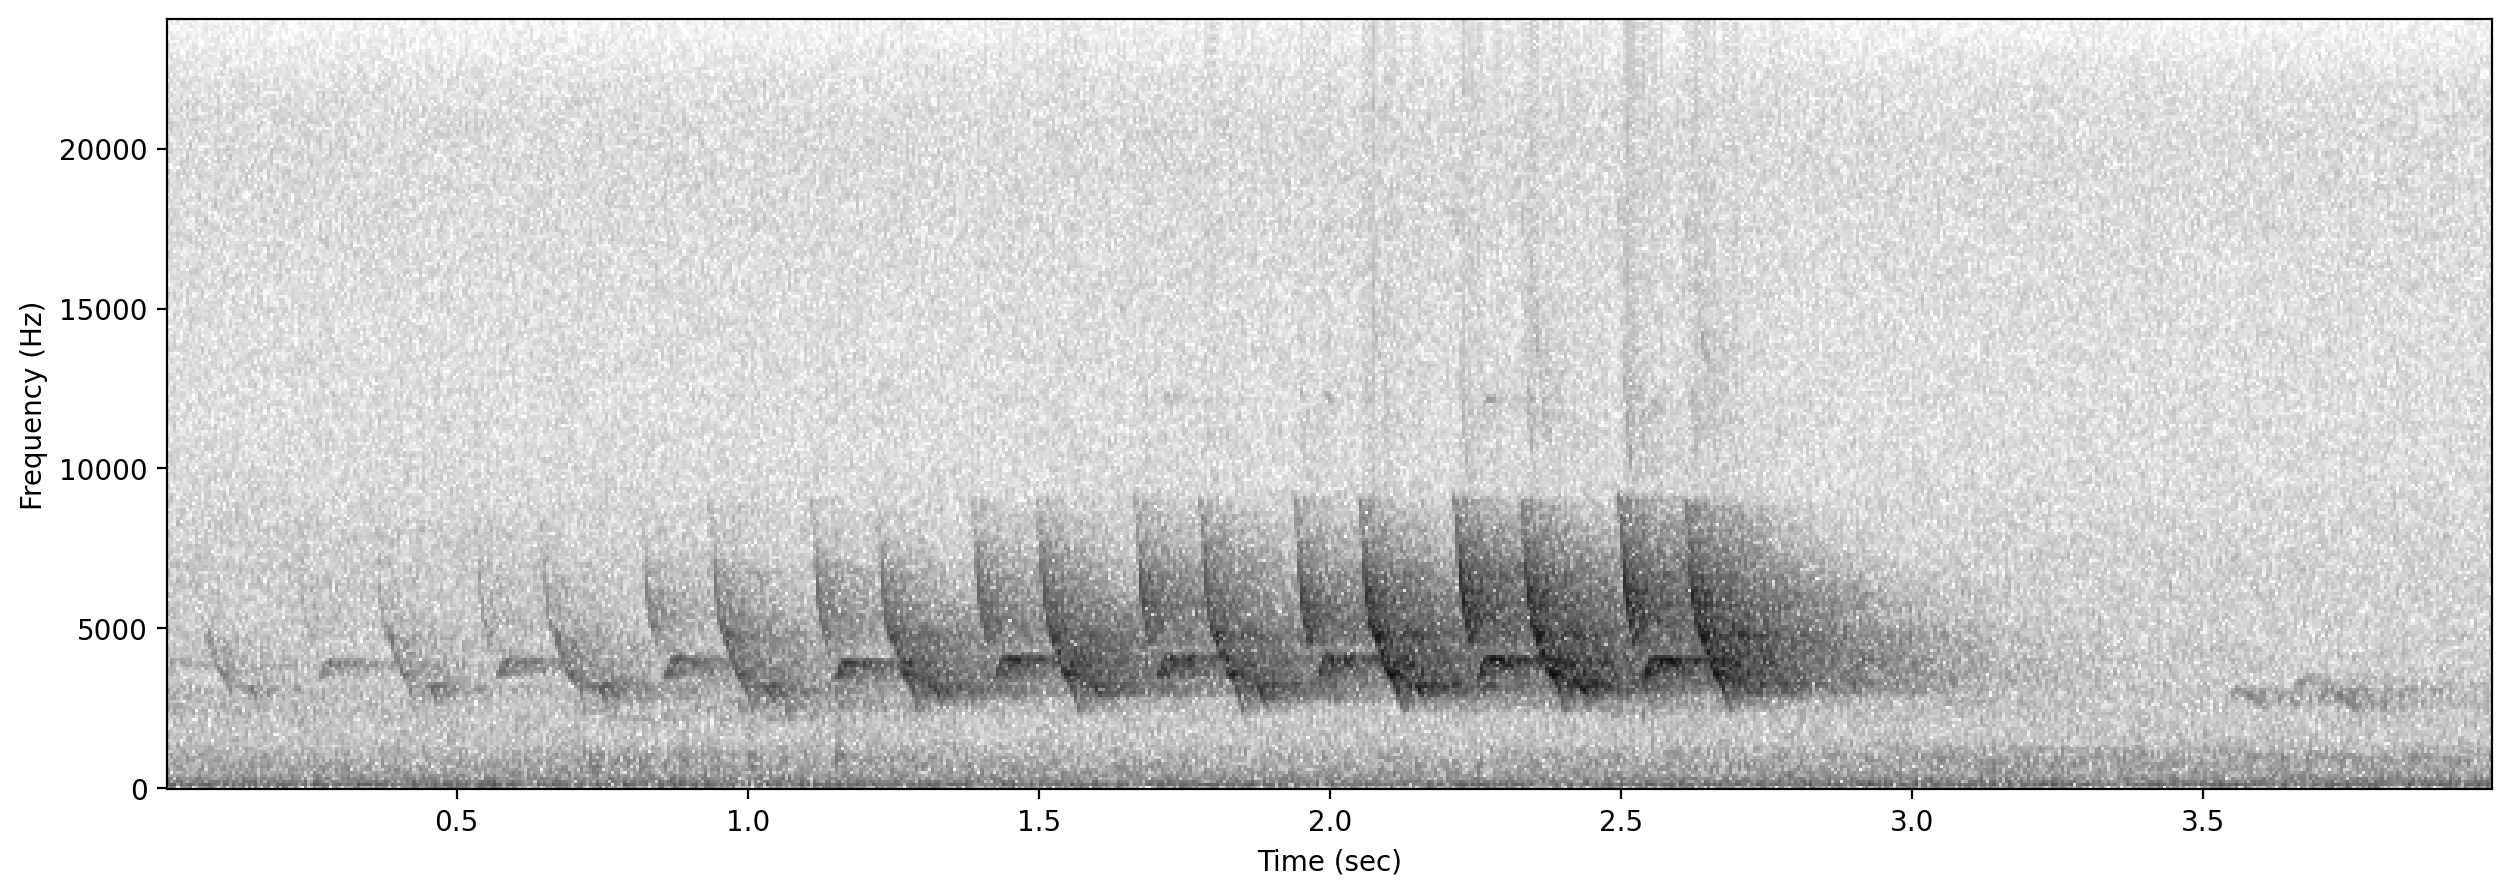

In [ ]:
to_annotate = val_df[val_df.nearest].reset_index()
while i < len(to_annotate):
    row = to_annotate.loc[i]
    if not row.nearest:
        i += 1
        continue
    print(f"idx: {i}  event: {row.event_id}")

    # load the audio and display spectrogram
    # closest_clip_row = val_df.loc[clip_df.distance.idxmin()]
    a = Audio.from_file(
        row.file, offset=row.song_center_time - view_seconds / 2, duration=view_seconds
    )
    # a=a.normalize()#.reduce_noise()
    # a.show_widget()
    # show widget for slowed-down version
    a.trim(1, 3)._spawn(sample_rate=a.sample_rate // 4).show_widget()

    Spectrogram.from_audio(a, overlap_fraction=0.5, window_samples=512).plot()
    response = input("x to quit, -1 to go back, or specific idx to jump to: ")
    if response == "x":
        break
    elif response == "-1":
        i -= 1
    else:
        # jump to specific index
        try:
            response = int(response)
            assert 0 < response < 1000
            i = response
        except:
            i += 1

    IPython.display.clear_output()

## update labels of other clips
After annotation is finished, use the annotations to update labels for other clips from the same events


In [45]:
val_labels = pd.read_csv(f"{splits_path}/val_df_labeled.csv")

val_labels = val_labels.set_index("event_id")
ann = val_labels.dropna(subset="aiid_label")

for e in ann.index.unique():
    val_labels.loc[e, "aiid_label"] = ann.at[e, "aiid_label"]
    val_labels.to_csv(f"{splits_path}/val_labels.csv")

In [57]:
labels = pd.read_csv(
    f"{splits_path}/test_annotated.csv", parse_dates=["event_timestamp"]
)

labels = labels.set_index("event_id")
ann = labels.dropna(subset="aiid_label")

for e in ann.index.unique():
    labels.loc[e, "aiid_label"] = ann.at[e, "aiid_label"]
labels.to_csv(f"{splits_path}/test_labels.csv")

In [58]:
labels.aiid_label.unique()

array(['31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', 'n', '43', '44', '45', '46'], dtype=object)

For each grid, plot the positions colored by annotator label

In [ ]:
labels["date"] = labels.event_timestamp.apply(lambda x: x.date())

event_id
SBT-6-76_oven_0000    2016-06-21
SBT-6-76_oven_0000    2016-06-21
SBT-6-76_oven_0000    2016-06-21
SBT-6-76_oven_0000    2016-06-21
SBT-6-76_oven_0000    2016-06-21
                         ...    
SBT-6-83_oven_0032    2016-06-27
SBT-6-83_oven_0032    2016-06-27
SBT-6-83_oven_0032    2016-06-27
SBT-6-83_oven_0032    2016-06-27
SBT-6-83_oven_0032    2016-06-27
Name: date, Length: 1267, dtype: object

SBT-3-7
SBT-6-76
SBT-6-83


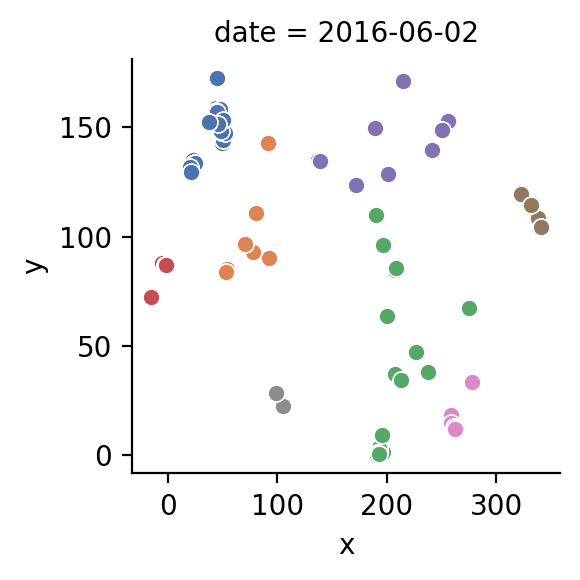

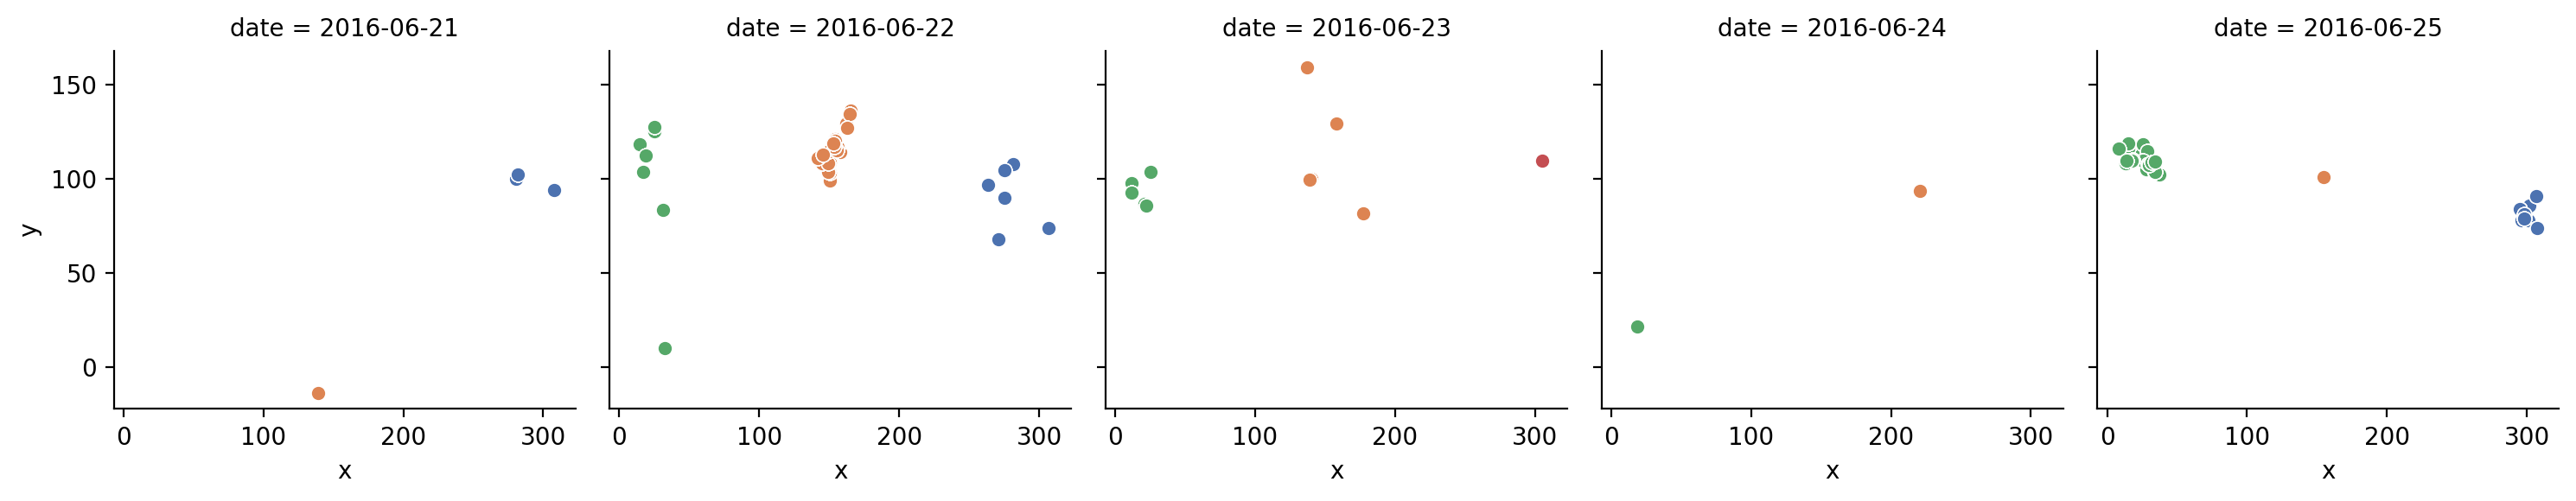

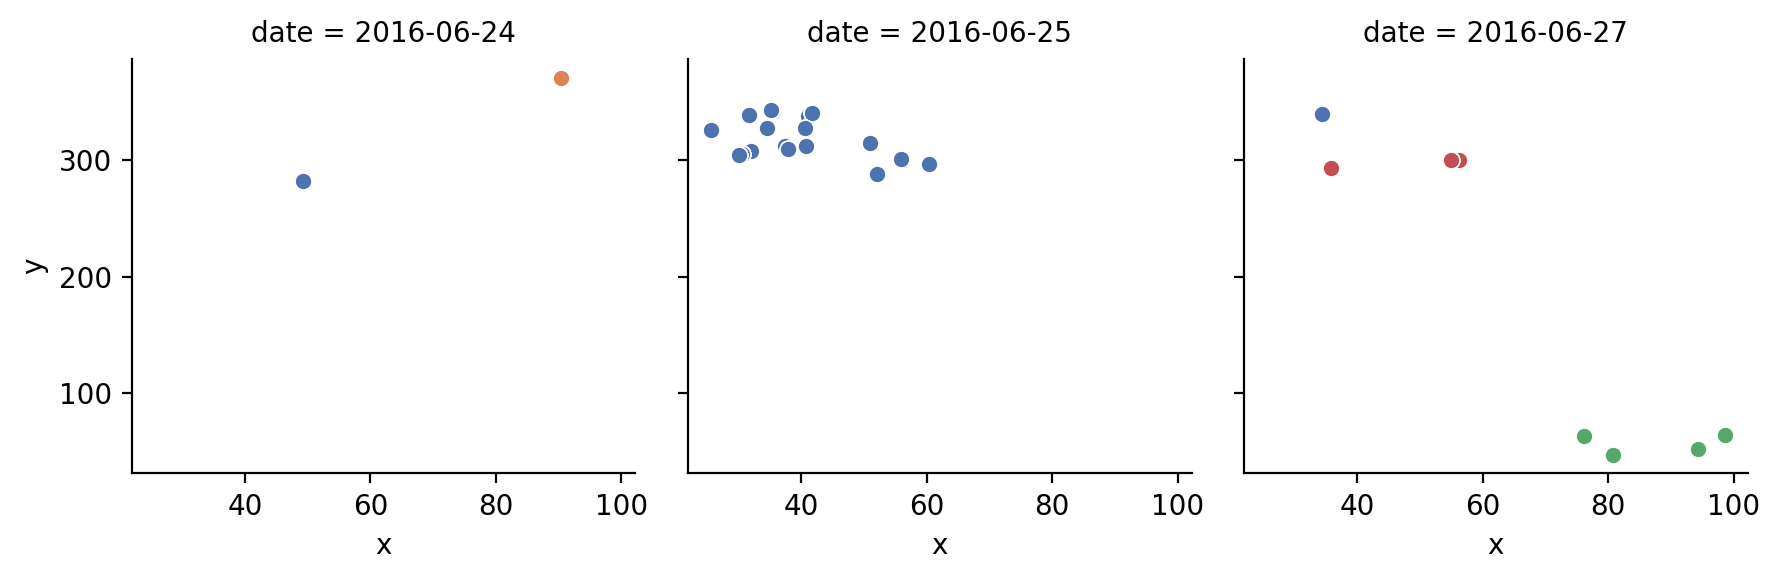

In [80]:
import seaborn as sns

figsize(15, 20)
for i, (grid, grid_labels) in enumerate(labels.groupby("array")):
    print(grid)
    grid_labels = grid_labels[
        grid_labels.aiid_label.apply(lambda x: x not in ("n", "u"))
    ]
    g = sns.FacetGrid(grid_labels, col="date", hue="aiid_label", palette="deep")
    g.map_dataframe(sns.scatterplot, x="x", y="y")
    # plt.axis('equal')
pass